In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import zipfile

In [2]:
train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.0)
test_data_gen  = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.0)

In [3]:
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip

--2022-11-20 08:37:29--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 172.217.212.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘horse-or-human.zip’

horse-or-human.zip  100%[===================>] 142.65M   291MB/s    in 0.5s    

2022-11-20 08:37:29 (291 MB/s) - ‘horse-or-human.zip’ saved [149574867/149574867]

--2022-11-20 08:37:29--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 172.217.212.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1148018

In [4]:
train_file = zipfile.ZipFile('/content/horse-or-human.zip', 'r')
test_file  = zipfile.ZipFile('/content/validation-horse-or-human.zip', 'r')

In [5]:
train_file.extractall('train-dir')
test_file.extractall('test-dir')

In [6]:
train_data = train_data_gen.flow_from_directory(
    '/content/train-dir',
    target_size = (150, 150),
    batch_size = 128,
    class_mode = 'binary'
)

test_data  = test_data_gen.flow_from_directory(
    '/content/test-dir',
    target_size = (150, 150),
    batch_size = 32,
    class_mode = 'binary'
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [ ]:
import os
from PIL import Image
import imageio
import numpy as np
image = []


class CallBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epochs, logs = {}):
        if len(self.model.history.history) > 0:
            f, ax = plt.subplots(1,2, figsize = (20,6))
            ax[0].plot(range(len(self.model.history.history['accuracy'])), self.model.history.history['accuracy'], label = "Training Accuracy")
            ax[0].plot(range(len(self.model.history.history['val_accuracy'])), self.model.history.history['val_accuracy'], label = "Testing Accuracy")
            ax[0].legend()
            ax[0].set_title(f"Accuracy - {epochs}")

            ax[1].plot(range(len(self.model.history.history['loss'])), self.model.history.history['loss'], label = "Training Loss")
            ax[1].plot(range(len(self.model.history.history['val_loss'])), self.model.history.history['val_loss'], label = "Testing Loss")
            ax[1].legend()
            ax[1].set_title(f"Loss - {epochs}")
            
            name = os.getcwd() + 'test_img.png'
            plt.savefig(name)
            image_ = Image.open(name)
            image.append(np.array(image_))
            os.remove(name)
        
        if logs['val_accuracy'] > 0.85:
            print(f"Model accuracy is more than {(logs['val_accuracy'] * 100)} %")
            self.model.stop_training = True
    def on_train_end(self, epochs, logs = {}):
        f, ax = plt.subplots(1,2, figsize = (20,6))
        ax[0].plot(range(len(self.model.history.history['accuracy'])), self.model.history.history['accuracy'], label = "Training Accuracy")
        ax[0].plot(range(len(self.model.history.history['val_accuracy'])), self.model.history.history['val_accuracy'], label = "Testing Accuracy")
        ax[0].legend()
        ax[0].set_title(f"Accuracy Final")

        ax[1].plot(range(len(self.model.history.history['loss'])), self.model.history.history['loss'], label = "Training Loss")
        ax[1].plot(range(len(self.model.history.history['val_loss'])), self.model.history.history['val_loss'], label = "Testing Loss")
        ax[1].legend()
        ax[1].set_title(f"Loss Final")
        
        name = os.getcwd() + 'test_img.png'
        plt.savefig(name)
        image_ = Image.open(name)
        image.append(np.array(image_))
        os.remove(name)

cb = CallBack()
model4 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), input_shape = (150,150,3), activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(128, (3,3), activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation = tf.keras.activations.relu),
    tf.keras.layers.Dense(512, activation = tf.keras.activations.relu),
    tf.keras.layers.Dense(256, activation = tf.keras.activations.relu),
    tf.keras.layers.Dense(128, activation = tf.keras.activations.relu),
    tf.keras.layers.Dense(1,  activation = tf.keras.activations.sigmoid)
])

model4.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001) , loss = tf.keras.losses.binary_crossentropy, metrics = ['accuracy'])
history = model4.fit(
    train_data,
    steps_per_epoch = train_data.n // train_data.batch_size,
    epochs = 100,
    verbose = 1,
    validation_data = test_data,
    validation_steps = test_data.n // test_data.batch_size,
    callbacks = [cb]
)
plt.show(block = False)
imageio.mimsave('./animation.gif' , image , fps = 1)

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style('darkgrid')

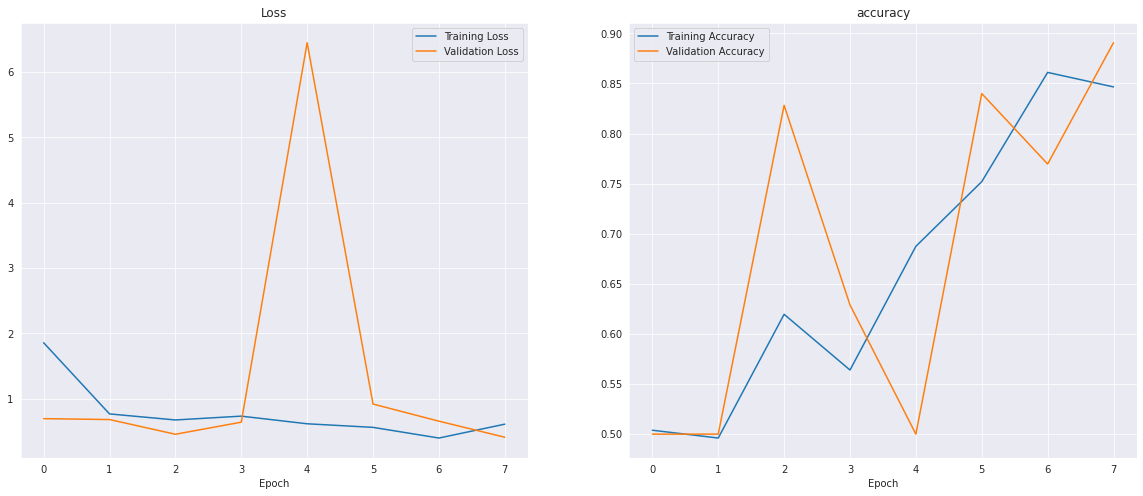

In [10]:
fig, ax = plt.subplots(1,2, figsize=(20,8))

ax[0].plot(np.arange(len(model4.history.history['loss'])), model4.history.history['loss'], label = 'Training Loss')
ax[0].plot(np.arange(len(model4.history.history['val_loss'])), model4.history.history['val_loss'], label = 'Validation Loss')
ax[0].legend()
ax[0].set_title('Loss')
ax[0].set_xlabel("Epoch")

ax[1].plot(np.arange(len(model4.history.history['accuracy'])), model4.history.history['accuracy'] , label = 'Training Accuracy')
ax[1].plot(np.arange(len(model4.history.history['val_accuracy'])), model4.history.history['val_accuracy'], label = 'Validation Accuracy')
ax[1].legend()
ax[1].set_title('accuracy')
ax[1].set_xlabel("Epoch")

fig.show()

1/1 [==============================] - 0s 15ms/step


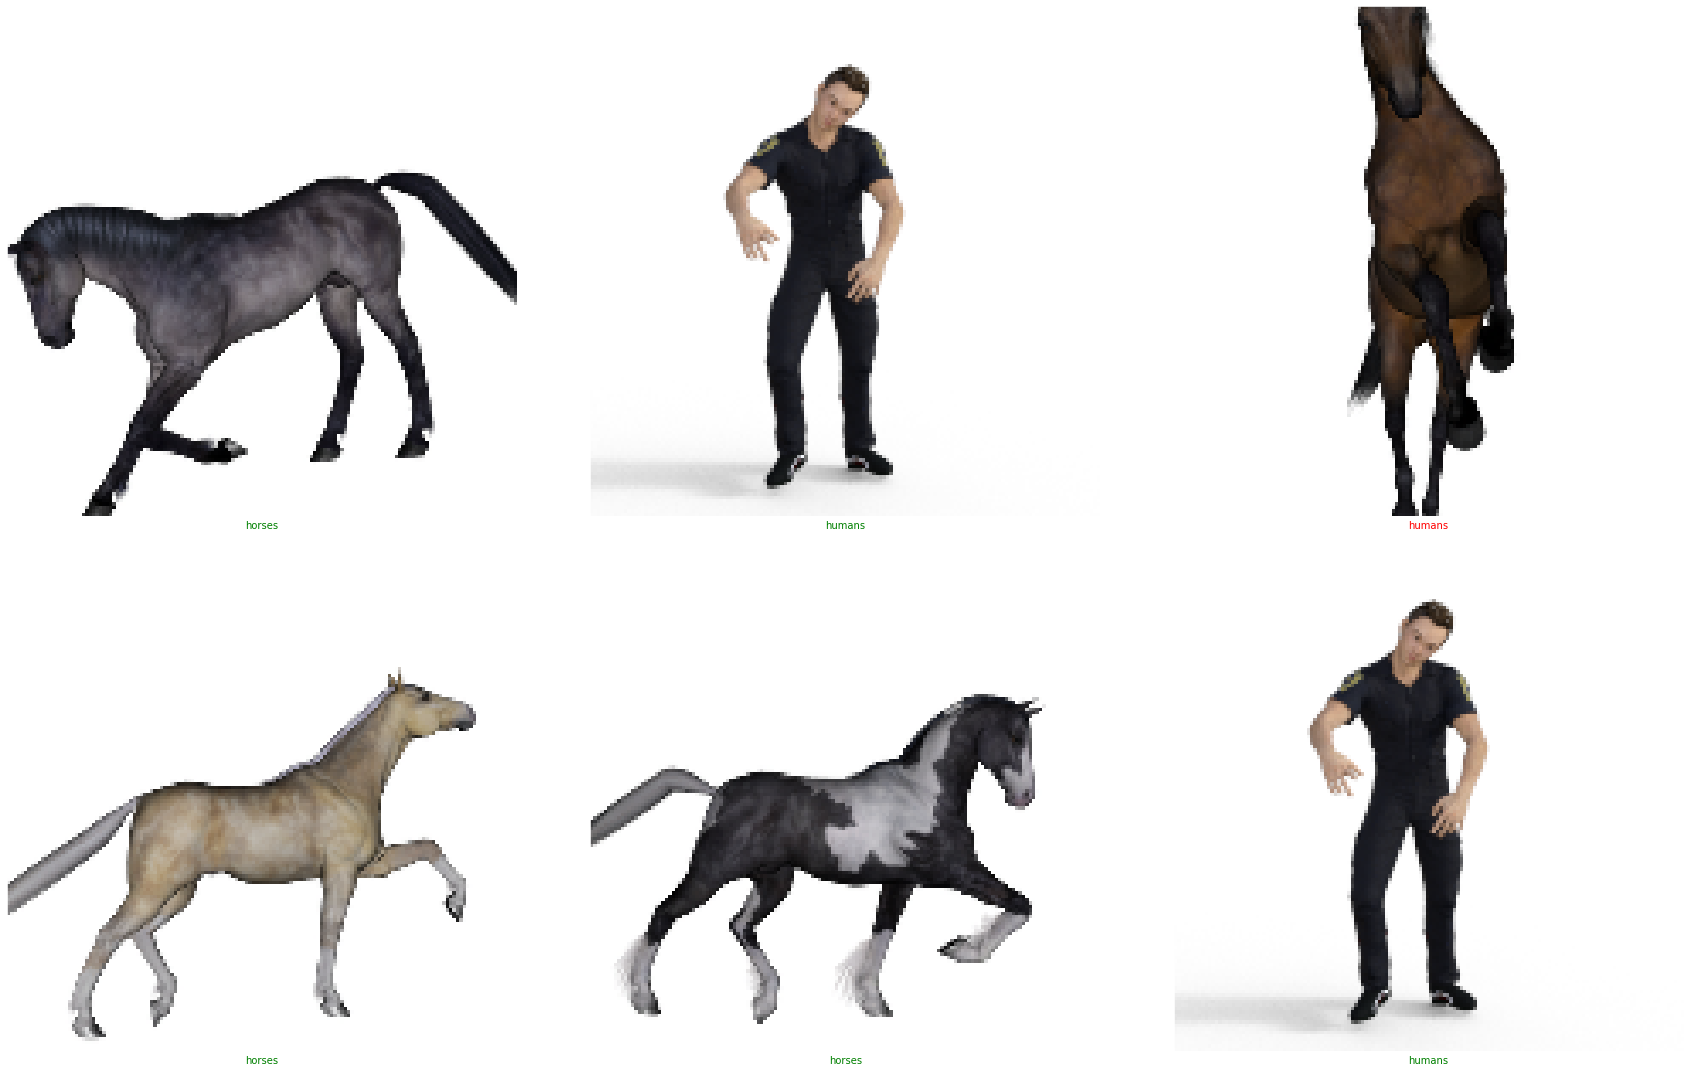

In [11]:
fig, ax = plt.subplots(2,3, figsize=(25,15))


for i in range(2):
    for j in range(0,3):
        random_val1 = np.random.randint(0,32)
        random_val2 = np.random.randint(0,4)
        test_img  = test_data[random_val2][0][random_val1].reshape(1,150,150,3)
        act_label = test_data[random_val2][1][random_val1]
        raw_label = int(model4.predict(test_img)[0][0] > 0.5)
        label = list(test_data.class_indices.keys())
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        
        ax[i][j].imshow(test_img[0])
        if raw_label == act_label:
            ax[i][j].set_xlabel(label[raw_label], c='green')
        else:
            ax[i][j].set_xlabel(label[raw_label], c='red')

fig.tight_layout()
fig.show()